In [117]:
# Setting up environment

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import joblib

from sklearn.preprocessing import StandardScaler

from dotenv import load_dotenv

load_dotenv()
mpl.rcParams['figure.figsize'] = (12, 10)

In [118]:
# drop colomn
def dropColomn(df, col):
    try:
        df = df.drop(col,1)
    except:
        print('colomn {0} not found'.format(col))
    return df

# split dataframe to feature target numpy array
def split_feature_label(df):
    return df.iloc[:, :-1].values, df.iloc[:, -1].values

In [136]:
# processing testing dataset

# import dataset
test_df = pd.read_csv('../datasets/testing.csv')

print(test_df.TenYearCHD.value_counts())

# drop colomn id
test_df = dropColomn(test_df, 'id')

# split features and labels
x_test, y_test = split_feature_label(test_df)

print('shape of testing feature: {0}'.format(x_test.shape))
print('shape of testing labels: {0}'.format(y_test.shape))

0    1086
1     185
Name: TenYearCHD, dtype: int64
colomn id not found
shape of testing feature: (1271, 14)
shape of testing labels: (1271,)


In [134]:
# processing training dataset
# import dataset
dataset = pd.read_csv('../datasets/training.csv')

# drop colomm id
dataset = dropColomn(dataset, 'id')

print(dataset.TenYearCHD.value_counts())

# split features and labels
x,y = split_feature_label(dataset)

print('shape of training feature: {0}'.format(x.shape))
print('shape of training labels: {0}'.format(y.shape))


colomn id not found
0    2508
1     459
Name: TenYearCHD, dtype: int64
shape of training feature: (2967, 14)
shape of training labels: (2967,)


In [121]:
dataset.head()

,sex,age,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,63,0,0.0,0.0,0,1,0,244.376147,151.0,88.0,26.578624,74.281818,83.801980,0
1,1,63,0,0.0,0.0,0,1,0,244.376147,145.5,80.0,26.578624,74.281818,83.801980,1
2,1,43,1,40.0,0.0,0,0,0,225.430380,114.0,81.0,25.289057,77.603774,80.842857,1
3,1,49,0,0.0,0.0,0,0,0,242.801527,114.0,82.0,25.388182,75.363636,78.395161,0
4,0,47,1,2.0,0.0,0,0,0,236.920290,133.0,86.0,25.277482,76.184397,85.572581,0


In [122]:
# split to training and validating dataset
from sklearn.model_selection import train_test_split

TESTSIZE = float(os.getenv('VALRATE'))
TESTRANDOMSTATE = int(os.getenv('VALRANDOMSTATE'))

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = TESTSIZE, random_state = TESTRANDOMSTATE)

print('shape of training feature: {0}'.format(x_train.shape))
print('shape of training labels: {0}'.format(y_train.shape))

print('shape of validation feature: {0}'.format(x_val.shape))
print('shape of validation labels: {0}'.format(y_val.shape))


shape of training feature: (2225, 14)
shape of training labels: (2225,)
shape of validation feature: (742, 14)
shape of validation labels: (742,)


In [123]:
# Scaling data using standar scaler
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_val = sc.transform(x_val)
x_test = sc.transform(x_test)

# save scaler variable into file
scaler_filename = '../model/scaler.save'
joblib.dump(sc, scaler_filename) 


['../model/scaler.save']

In [124]:
# building model

BATCH_SIZE = int(os.getenv('BATCHSIZE'))
EPOCHS = int(os.getenv('EPOCH'))

METRICS = [
    # keras.metrics.TruePositives(name='tp'),
    # keras.metrics.FalsePositives(name='fp'),
    # keras.metrics.TrueNegatives(name='tn'),
    # keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    # keras.metrics.AUC(name='auc'),
    # keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS ):
    model = keras.Sequential([
        keras.layers.Dense(
            14, activation='relu',
            input_shape=(x_train.shape[-1],)),
        keras.layers.Dense(
            64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.02),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=32,
    mode='max',
    restore_best_weights=True)

In [125]:
model = make_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 14)                210       
_________________________________________________________________
dense_27 (Dense)             (None, 64)                960       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 65        
Total params: 1,235
Trainable params: 1,235
Non-trainable params: 0
_________________________________________________________________


In [126]:
zero_bias_history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=early_stopping)

Epoch 1/1024
35/35 [==============================] - 1s 21ms/step - loss: 0.4387 - accuracy: 0.8292 - precision: 0.1750 - recall: 0.0198 - val_loss: 0.3894 - val_accuracy: 0.8585 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/1024
35/35 [==============================] - 0s 2ms/step - loss: 0.3922 - accuracy: 0.8418 - precision: 0.7500 - recall: 0.0085 - val_loss: 0.3810 - val_accuracy: 0.8652 - val_precision: 0.7778 - val_recall: 0.0667
Epoch 3/1024
35/35 [==============================] - 0s 2ms/step - loss: 0.3875 - accuracy: 0.8454 - precision: 0.7500 - recall: 0.0424 - val_loss: 0.3882 - val_accuracy: 0.8639 - val_precision: 0.7500 - val_recall: 0.0571
Epoch 4/1024
35/35 [==============================] - 0s 2ms/step - loss: 0.3834 - accuracy: 0.8422 - precision: 0.5405 - recall: 0.0565 - val_loss: 0.3824 - val_accuracy: 0.8585 - val_precision: 0.5000 - val_recall: 0.0952
Epoch 5/1024
35/35 [==============================] - 0s 2ms/step - loss: 0.3838 - accuracy: 0.

In [127]:
model.save('model/ann_model/')

INFO:tensorflow:Assets written to: model/ann_model/assets


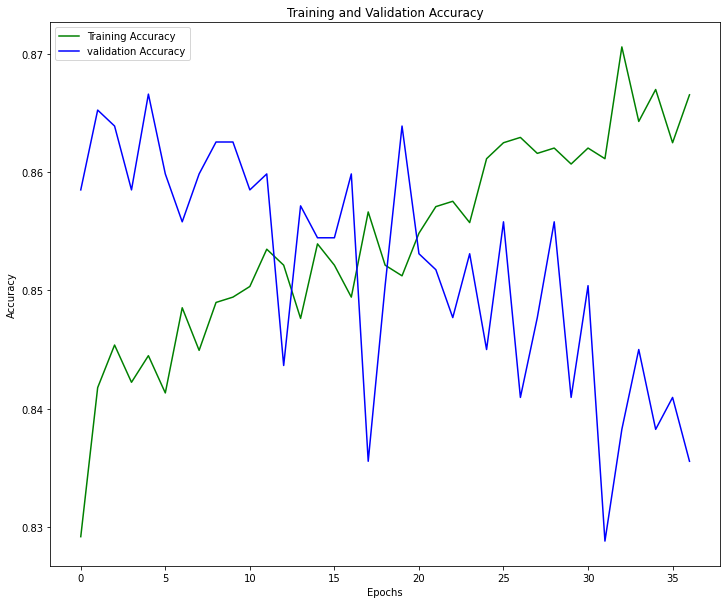

In [128]:
loss_train = zero_bias_history.history['accuracy']
loss_val = zero_bias_history.history['val_accuracy']
epochs = range(len(zero_bias_history.history['accuracy']))
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

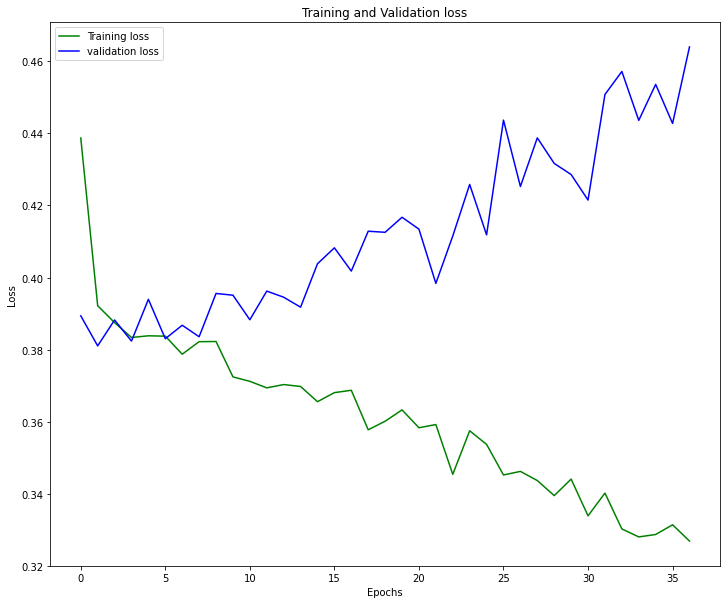

In [129]:
loss_train = zero_bias_history.history['loss']
loss_val = zero_bias_history.history['val_loss']
epochs = range(len(zero_bias_history.history['loss']))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [130]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): {0}, with percentage : {1}'.format(cm[0][0], cm[0][0]/len(labels)))
    print('Legitimate Transactions Incorrectly Detected (False Positives): {0}, with percentage : {1}'.format(cm[0][1], cm[0][1]/len(labels)))
    print('Fraudulent Transactions Missed (False Negatives): {0}, with percentage : {1}'.format(cm[1][0], cm[1][0]/len(labels)))
    print('Fraudulent Transactions Detected (True Positives): {0}, with percentage : {1}'.format(cm[1][1], cm[1][1]/len(labels)))
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

    print('Accuracy : ', accuracy_score(labels, predictions > p))
    print('Recall : ', recall_score(labels, predictions > p))
    print('Precision : ', precision_score(labels, predictions > p))

[[0.29042849 1.        ]
 [0.04609892 0.        ]
 [0.19541401 0.        ]
 ...
 [0.47545972 0.        ]
 [0.26111561 0.        ]
 [0.03595027 0.        ]]
Legitimate Transactions Detected (True Negatives): 1073, with percentage : 0.8442171518489379
Legitimate Transactions Incorrectly Detected (False Positives): 13, with percentage : 0.010228166797797011
Fraudulent Transactions Missed (False Negatives): 172, with percentage : 0.13532651455546812
Fraudulent Transactions Detected (True Positives): 13, with percentage : 0.010228166797797011
Total Fraudulent Transactions:  185
Accuracy :  0.8544453186467349
Recall :  0.07027027027027027
Precision :  0.5


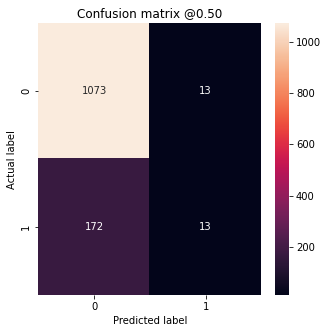

In [131]:
# predicting test data
y_pred = model.predict(x_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))
plot_cm(y_test, y_pred)

[[0.14728966 0.        ]
 [0.10897195 0.        ]
 [0.37429643 0.        ]
 ...
 [0.26039118 0.        ]
 [0.12557819 0.        ]
 [0.32160783 0.        ]]
Legitimate Transactions Detected (True Negatives): 631, with percentage : 0.8504043126684636
Legitimate Transactions Incorrectly Detected (False Positives): 6, with percentage : 0.008086253369272238
Fraudulent Transactions Missed (False Negatives): 93, with percentage : 0.12533692722371967
Fraudulent Transactions Detected (True Positives): 12, with percentage : 0.016172506738544475
Total Fraudulent Transactions:  105
Accuracy :  0.866576819407008
Recall :  0.11428571428571428
Precision :  0.6666666666666666


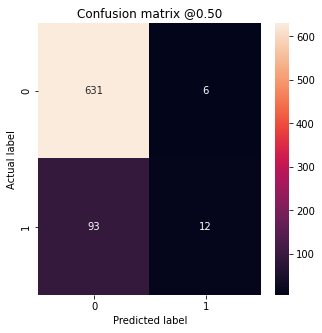

In [132]:
# conf matrix on validation data

y_pred = model.predict(x_val)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_val.reshape(len(y_val),1)),1))

plot_cm(y_val, y_pred)